## Try different Boosting models to get better predictions

In [1]:
from warnings import filterwarnings
filterwarnings("ignore")

import sys
sys.path.append('../common')

from print_more_stuff import print_more_stuff
from regression_models import dosomething
from preprocessing import mean_and_std

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
outliers_df = pd.read_csv("geocoded.csv")
outliers_df.drop(columns=["Unnamed: 0"],inplace=True)

In [3]:
outliers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12242 entries, 0 to 12241
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    12242 non-null  int64  
 1   bed             12242 non-null  float64
 2   bath            12242 non-null  float64
 3   acre_lot        12242 non-null  float64
 4   zip_code        12242 non-null  float64
 5   house_size      12242 non-null  float64
 6   prev_sold_date  12242 non-null  object 
 7   price           12242 non-null  float64
 8   prev_sold_year  12242 non-null  int64  
 9   zip_code_str    12242 non-null  int64  
 10  latitude        12242 non-null  float64
 11  longitude       12242 non-null  float64
 12  county          12242 non-null  int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 1.2+ MB


In [4]:
outliers_df.head()

,Unnamed: 0.1,bed,bath,acre_lot,zip_code,house_size,prev_sold_date,price,prev_sold_year,zip_code_str,latitude,longitude,county
0,0,3.0,2.0,2.02,12521.0,1600.0,2021-11-24,425000.0,2021,12521,42.171335,-73.650487,19
1,1,4.0,2.0,0.24,12521.0,1239.0,2018-02-01,225000.0,2018,12521,42.171335,-73.650487,19
2,2,3.0,3.0,0.09,12521.0,1320.0,2020-02-28,995000.0,2020,12521,42.171335,-73.650487,19
3,3,3.0,3.0,5.00,12521.0,2517.0,2017-05-30,895000.0,2017,12521,42.171335,-73.650487,19
4,4,3.0,2.0,1.20,12546.0,1350.0,2018-08-31,375000.0,2018,12546,41.948000,-73.523349,19


#### Find the zip code of that has the most houses.

In [5]:
groupby_zipcode = outliers_df.groupby(["zip_code"])["zip_code"].count().sort_values(ascending=False)
groupby_zipcode_df = pd.DataFrame(groupby_zipcode).rename(columns={"zip_code":"count"}).reset_index()
first_zipcode = groupby_zipcode_df.iloc[0]["zip_code"]
first_zipcode

10023.0

#### Find the rows of the zip code that has the most houses.

In [6]:
one_zipcode_df = outliers_df[outliers_df["zip_code"].isin([first_zipcode])]

In [7]:
one_zipcode_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 150 entries, 3689 to 3838
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Unnamed: 0.1    150 non-null    int64  
 1   bed             150 non-null    float64
 2   bath            150 non-null    float64
 3   acre_lot        150 non-null    float64
 4   zip_code        150 non-null    float64
 5   house_size      150 non-null    float64
 6   prev_sold_date  150 non-null    object 
 7   price           150 non-null    float64
 8   prev_sold_year  150 non-null    int64  
 9   zip_code_str    150 non-null    int64  
 10  latitude        150 non-null    float64
 11  longitude       150 non-null    float64
 12  county          150 non-null    int64  
dtypes: float64(8), int64(4), object(1)
memory usage: 16.4+ KB


#### Create an object to pass to the function that will normalize the data

In [8]:
params = {
    "data":one_zipcode_df,
    "features_a":["prev_sold_year","latitude","longitude","zip_code"],
    "features_n":["bed","bath","acre_lot","house_size","price"]
}
normalize_df = mean_and_std(params)
normalize_df.tail()

,bed,bath,acre_lot,house_size,price,prev_sold_year,latitude,longitude,zip_code
3834,0.158628,0.278238,-0.197783,-0.097337,0.013886,2017,40.775921,-73.982607,10023.0
3835,-0.974429,-0.739706,-0.197783,-0.097337,-0.230905,2017,40.775921,-73.982607,10023.0
3836,0.158628,0.278238,-0.197783,-0.097337,-0.106920,2019,40.775921,-73.982607,10023.0
3837,0.158628,0.278238,-0.197783,-0.097337,-0.361248,2019,40.775921,-73.982607,10023.0
3838,1.291685,-0.739706,-0.197783,-0.097337,-0.908053,2017,40.775921,-73.982607,10023.0


#### Create a variable for the correlation of the normalized data

In [9]:
correlation = normalize_df[["acre_lot","bed","bath","house_size","prev_sold_year","price"]].corr()
correlation["price"]

acre_lot          0.170108
bed               0.626874
bath              0.909782
house_size        0.798127
prev_sold_year   -0.017182
price             1.000000
Name: price, dtype: float64

#### Display a Heatmap with the correlated data

Text(0.5, 1.0, 'Correlation Between Variables')

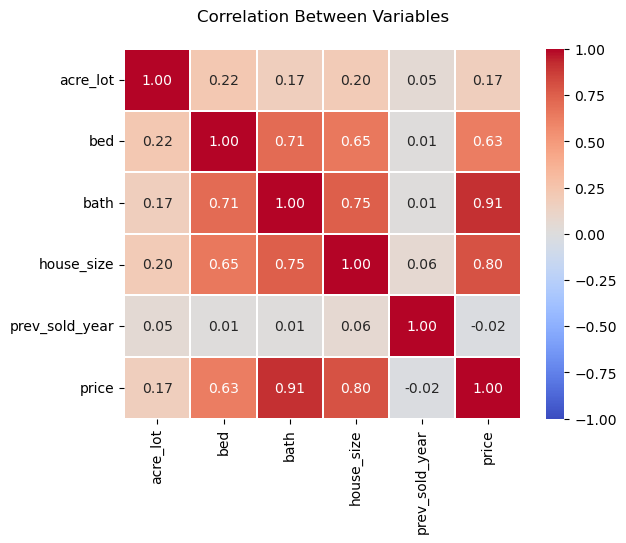

In [10]:
sns.heatmap(correlation, vmin=-1, vmax=1, cmap = 'coolwarm', annot=True, fmt='.2f', linewidths=0.1)
plt.title("Correlation Between Variables", pad=20)

#### Create a variable to hold the features that correlate with the price feature between 0.20 and 0.80

In [11]:
'''
'''
savefeatures = ["latitude","longitude"]
for feature, value in correlation["price"].items():
    if abs(value) < 0.81 and abs(value) >= 0.20:
        savefeatures.append(feature)

print(savefeatures)

['latitude', 'longitude', 'bed', 'house_size']


#### Create common variables to store frequently used values.

In [12]:
#features = ["latitude","longitude","bed","bath","house_size"]
features = savefeatures
num_features_to_select = len(features)-1
random_state_value = 42

#### Datasets for modeling, testing the models, and making predictions.

In [13]:
X = normalize_df[savefeatures]
y = normalize_df["price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=random_state_value)

#### Variable to store the results generated by the models.

In [14]:
results_dict = {"model":[], "explained variance score":[],"mae score":[],"mse score":[],"r2 score":[], "mean fit time":[]}

#### Function to format the results generated by the models.

In [15]:
def results_dict_append(rtnval):
    results_dict["model"].append(rtnval["model"])
    results_dict["explained variance score"].append(rtnval["explained variance score"])
    results_dict["mae score"].append(rtnval["mae score"])
    results_dict["mse score"].append(rtnval["mse score"])
    results_dict["r2 score"].append(rtnval["r2 score"])
    results_dict["mean fit time"].append(rtnval["mean fit time"])

#### Ada Boosting

In [16]:
adaboost = dosomething("Ada Boost","Ada Boost", normalize_df, features, "price")
results_dict_append(adaboost["results"])
adaboost_predict = adaboost["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'house_size']
Ada Boost EVS = 0.749018406
Ada Boost MSE = 0.233654
Ada Boost MAE = 0.361710
Ada Boost R2 = 0.726146
Ada Boost Fit Time = 0.003254270553588867


#### Gradient Boosting

In [17]:
gbr = dosomething("Gradient Boosting","Gradient Boosting", normalize_df, features, "price")
results_dict_append(gbr["results"])
gbr_predict = gbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'house_size']
Gradient Boosting EVS = 0.794410909
Gradient Boosting MSE = 0.175412
Gradient Boosting MAE = 0.316163
Gradient Boosting R2 = 0.794408
Gradient Boosting Fit Time = 0.02203812599182129


#### Hist Gradient Boosting

In [18]:
histgbr = dosomething("Hist Gradient Boosting","Hist Gradient Boosting", normalize_df, features, "price")
results_dict_append(histgbr["results"])
histgbr_predict = histgbr["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'house_size']
Hist Gradient Boosting EVS = 0.721259049
Hist Gradient Boosting MSE = 0.237900
Hist Gradient Boosting MAE = 0.344220
Hist Gradient Boosting R2 = 0.721169
Hist Gradient Boosting Fit Time = 0.07380976676940917


#### Random Forest

In [19]:
rf = dosomething("Random Forest","Random Forest", normalize_df, features, "price")
results_dict_append(rf["results"])
rf_predict = rf["predictions"]

The selected features are: ['latitude', 'longitude', 'bed', 'house_size']
Random Forest EVS = 0.794098279
Random Forest MSE = 0.175852
Random Forest MAE = 0.322214
Random Forest R2 = 0.793892
Random Forest Fit Time = 0.06890559196472168


#### Graphing the results works best when the data is provided in a DataFrame.

In [20]:
adaboost_predict_df = pd.DataFrame(adaboost_predict).reset_index()
adaboost_predict_df.rename(columns={0: "prediction"},inplace=True)

gbr_predict_df = pd.DataFrame(gbr_predict).reset_index()
gbr_predict_df.rename(columns={0: "prediction"},inplace=True)

rf_predict_df = pd.DataFrame(rf_predict).reset_index()
rf_predict_df.rename(columns={0: "prediction"},inplace=True)

histgbr_predict_df = pd.DataFrame(histgbr_predict).reset_index()
histgbr_predict_df.rename(columns={0: "prediction"},inplace=True)

y_test_df = pd.DataFrame(y_test).reset_index()

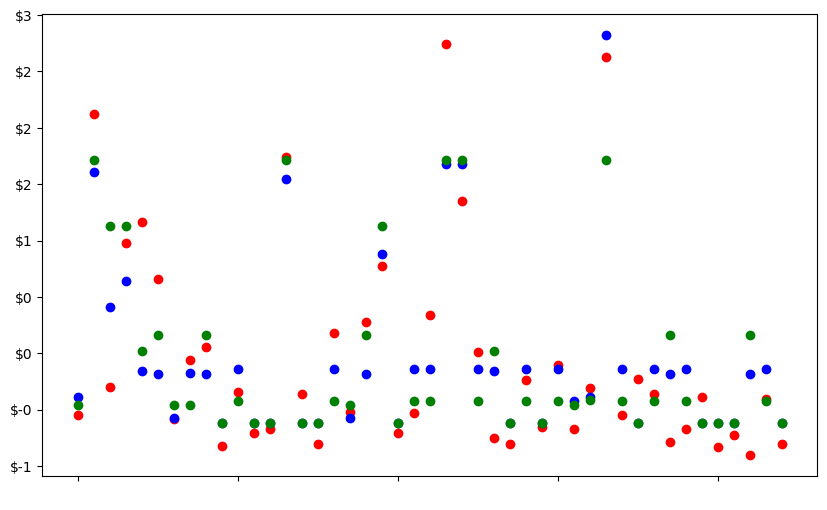

In [21]:
fig, ax = plt.subplots(figsize=(10, 6))

ax.ticklabel_format(style='plain')
ax.yaxis.set_major_formatter('${x:1,.0f}')
ax.xaxis.set_major_formatter(' ')

plt.scatter(y_test_df.index,y_test_df["price"], color="red")
plt.scatter(gbr_predict_df.index,gbr_predict_df["prediction"], color="blue")
plt.scatter(histgbr_predict_df.index,histgbr_predict_df["prediction"], color="green")
#plt.scatter(adaboost_predict_df.index,adaboost_predict_df["prediction"], color="black")
#plt.scatter(rf_predict_df.index,rf_predict_df["prediction"], color="black")
plt.show()

#### Output the results so they can be copied into another Notebook comparing the results of all the models.

In [22]:
results_dict

{'model': ['Ada Boost',
  'Gradient Boosting',
  'Hist Gradient Boosting',
  'Random Forest'],
 'explained variance score': ['0.749018406',
  '0.794410909',
  '0.721259049',
  '0.794098279'],
 'mae score': ['0.361710', '0.316163', '0.344220', '0.322214'],
 'mse score': ['0.233654', '0.175412', '0.237900', '0.175852'],
 'r2 score': ['0.726146', '0.794408', '0.721169', '0.793892'],
 'mean fit time': [0.003254270553588867,
  0.02203812599182129,
  0.07380976676940917,
  0.06890559196472168]}

In [23]:
model_comparisons = pd.DataFrame(results_dict).set_index('model')
model_comparisons

,explained variance score,mae score,mse score,r2 score,mean fit time
model,,,,,
Ada Boost,0.749018406,0.361710,0.233654,0.726146,0.003254
Gradient Boosting,0.794410909,0.316163,0.175412,0.794408,0.022038
Hist Gradient Boosting,0.721259049,0.344220,0.237900,0.721169,0.073810
Random Forest,0.794098279,0.322214,0.175852,0.793892,0.068906


In [25]:
tohtml = model_comparisons.to_html()
#tohtml